In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_circles
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(42)

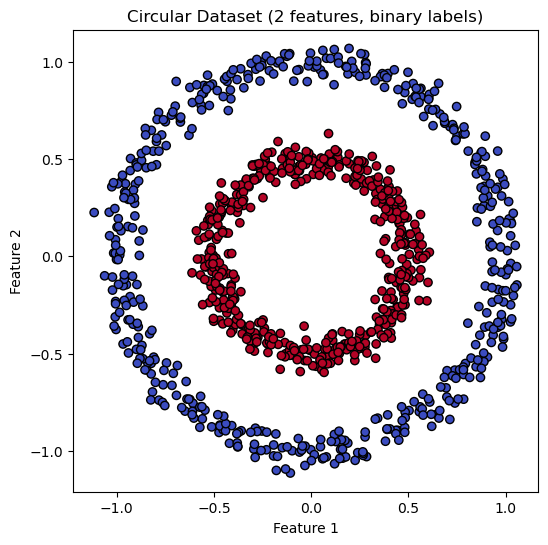

In [2]:

# Create a circular (concentric circles) dataset
X, y = make_circles(
    n_samples=1000,      # number of samples
    noise=0.05,         # add some noise for realism
    factor=0.5,         # scale factor between inner and outer circle
    random_state=42     # reproducibility
)

# Visualize the dataset
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k')
plt.title("Circular Dataset (2 features, binary labels)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.axis("equal")
plt.show()

In [3]:
print(X.shape)
print(y.shape)

(1000, 2)
(1000,)


In [4]:
print(X[:4])
print(y[:4])

[[ 0.45259239  0.16843331]
 [-0.43802652  0.11990049]
 [-0.5322243   0.18435902]
 [-0.30140181  0.40078207]]
[1 1 1 1]


In [5]:
# Create a dataset for: tarin=70%, test=10%, Validation=30%
def split_train_test_val(features, targets, train_rate = 0.7, test_rate = 0.1, val_rate = 0.2):
    size_train = int(len(features)*train_rate)
    size_test =  int(len(features)*test_rate)

    train_features = torch.tensor(features[:size_train], dtype=torch.float32)
    train_targets = torch.tensor(targets[:size_train], dtype=torch.float32).unsqueeze(1)

    test_features = torch.tensor(features[size_train:size_train+size_test], dtype=torch.float32)
    test_targets = torch.tensor(targets[size_train:size_train+size_test], dtype=torch.float32).unsqueeze(1)

    val_features = torch.tensor(features[size_train+size_test:], dtype=torch.float32)
    val_targets = torch.tensor(targets[size_train+size_test:], dtype=torch.float32).unsqueeze(1)


    return train_features, train_targets, test_features, test_targets, val_features, val_targets

In [6]:
X_train, y_train, X_test, y_test, X_val, y_val = split_train_test_val(X, y, train_rate = 0.7, test_rate = 0.1, val_rate = 0.2)

In [7]:
print(f" X_train: {len(X_train)}, {X_train.shape}, || X_test: {len(X_test)}, {X_test.shape}"
      f" || X_validation: {len(X_val)}, {X_val.shape}")
print(X_train[:2])
print(y_train[:2])

 X_train: 700, torch.Size([700, 2]), || X_test: 100, torch.Size([100, 2]) || X_validation: 200, torch.Size([200, 2])
tensor([[ 0.4526,  0.1684],
        [-0.4380,  0.1199]])
tensor([[1.],
        [1.]])


In [8]:
# Define a simple binary classification model

class SimpleBinaryClassificationModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=16):
        super(SimpleBinaryClassificationModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid() # # Output probability between 0 and 1
        )

    def forward(self, x):
        return self.network(x)


In [9]:
learning_rate = 0.01
model_1 = SimpleBinaryClassificationModel(input_size=2, hidden_size=4)

criterion = nn.BCELoss()  # ← Use BCELoss instead of BCEWithLogitsLoss since you have Sigmoid
optimizer = optim.Adam(model_1.parameters(), lr=learning_rate)

In [10]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    y_pred_classes = (y_pred > 0.5).float()
    correct = (y_pred_classes == y_true).float().sum()
    acc = correct / len(y_true)
    return acc * 100

In [11]:
def train_model(model, train_features, train_targets, test_features, test_targets, epochs=50):
    
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        
        train_predictions = model(train_features)  # These are probabilities [0,1]
        train_loss = criterion(train_predictions, train_targets)  # Use raw probabilities
        
        train_accuracy = accuracy_fn(y_true=train_targets, y_pred=train_predictions)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Evaluation phase
        model.eval()
        with torch.no_grad():
            test_predictions = model(test_features)  
            test_loss = criterion(test_predictions, test_targets)  # Use raw probabilities
            test_accuracy = accuracy_fn(y_true=test_targets, y_pred=test_predictions)

        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        # Print every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}] | "
                  f"Train Loss: {train_loss.item():.4f} | Train Acc: {train_accuracy:.2f}% | "
                  f"Test Loss: {test_loss.item():.4f} | Test Acc: {test_accuracy:.2f}%")

    
    return train_losses, test_losses, train_accuracies, test_accuracies

In [12]:
# Train the model_1
print("Model is going to training ...")
train_losses_model_1, test_losses_model_1, train_accuracies_model_1, test_accuracies_model_1 = train_model(
    model_1, X_train, y_train, X_test, y_test, epochs=100)

Model is going to training ...
Epoch [0/100] | Train Loss: 0.7759 | Train Acc: 48.71% | Test Loss: 0.6743 | Test Acc: 60.00%
Epoch [10/100] | Train Loss: 0.7225 | Train Acc: 48.71% | Test Loss: 0.6634 | Test Acc: 60.00%
Epoch [20/100] | Train Loss: 0.6950 | Train Acc: 49.71% | Test Loss: 0.6677 | Test Acc: 69.00%
Epoch [30/100] | Train Loss: 0.6845 | Train Acc: 51.86% | Test Loss: 0.6772 | Test Acc: 50.00%
Epoch [40/100] | Train Loss: 0.6801 | Train Acc: 50.57% | Test Loss: 0.6808 | Test Acc: 49.00%
Epoch [50/100] | Train Loss: 0.6758 | Train Acc: 51.14% | Test Loss: 0.6774 | Test Acc: 49.00%
Epoch [60/100] | Train Loss: 0.6714 | Train Acc: 51.86% | Test Loss: 0.6704 | Test Acc: 51.00%
Epoch [70/100] | Train Loss: 0.6668 | Train Acc: 52.43% | Test Loss: 0.6627 | Test Acc: 53.00%
Epoch [80/100] | Train Loss: 0.6615 | Train Acc: 53.14% | Test Loss: 0.6544 | Test Acc: 54.00%
Epoch [90/100] | Train Loss: 0.6550 | Train Acc: 54.71% | Test Loss: 0.6451 | Test Acc: 57.00%


In [13]:
print(model_1)

SimpleBinaryClassificationModel(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [14]:
summary(model_1, input_size=X_train.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 700, 4]              12
              ReLU-2               [-1, 700, 4]               0
            Linear-3               [-1, 700, 1]               5
           Sigmoid-4               [-1, 700, 1]               0
Total params: 17
Trainable params: 17
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.00
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


In [15]:
# Evaluate the model
def evaluate_model(model, val_features, val_targets):
    model.eval()
    with torch.no_grad():
        predictions = model(val_features)
        loss = criterion(predictions, val_targets)
        return loss.item(), predictions

val_loss, val_predictions = evaluate_model(model_1, X_val, y_val)
print(f"\nTest Loss: {val_loss:.4f}")


Test Loss: 0.6562


In [16]:
# # Make predictions on new data
def predict(model, X_1, X_2):
    model.eval()
    with torch.no_grad():
        # Ensure input is float tensor
        input_tensor = torch.tensor([X_1, X_2], dtype = torch.float32)
        prediction = model(input_tensor)
        return prediction.item()

predicted_label = round(predict(model_1, 1, 1))
print("Predicted label is: ", predicted_label)

Predicted label is:  1


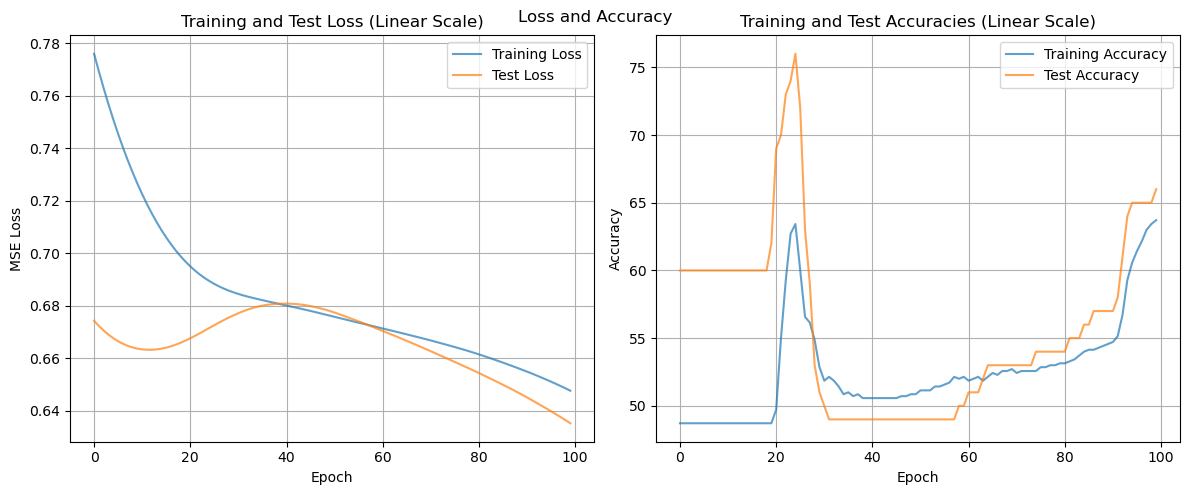

In [17]:
# Plot training and test losses

def plot_loss_accuracy(train_losses, test_losses, train_accuracies, test_accuracies, alpha=0.7):

    fig, axes = plt.subplots(1,2,figsize=(12, 5)) 

    axes[0].plot(train_losses, label='Training Loss', alpha=0.7)
    axes[0].plot(test_losses, label='Test Loss', alpha=0.7)
    axes[0].set_title("Training and Test Loss (Linear Scale)")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("MSE Loss")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(train_accuracies, label='Training Accuracy', alpha=0.7)
    axes[1].plot(test_accuracies, label='Test Accuracy', alpha=0.7)
    axes[1].set_title("Training and Test Accuracies (Linear Scale)")
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    # Adjust spacing between subplots
    plt.tight_layout()
    
    fig.suptitle('Loss and Accuracy')

    plt.show()

plot_loss_accuracy(train_losses_model_1, test_losses_model_1, train_accuracies_model_1, test_accuracies_model_1)

In [18]:
# Define a simple binary classification model

class TwoHiddenLayerBinaryClassificationModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=16):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, 1),
            nn.Sigmoid() # # Output probability between 0 and 1
        )

    def forward(self, x):
        return self.network(x)


In [19]:
learning_rate = 0.01
model_2 = TwoHiddenLayerBinaryClassificationModel(input_size=2, hidden_size=16)
criterion = nn.BCELoss()  # ← Use BCELoss instead of BCEWithLogitsLoss since you have Sigmoid
optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)

In [20]:
print(model_2)

TwoHiddenLayerBinaryClassificationModel(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [21]:
summary(model_2, input_size=X_train.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 700, 16]              48
              ReLU-2              [-1, 700, 16]               0
            Linear-3               [-1, 700, 8]             136
              ReLU-4               [-1, 700, 8]               0
            Linear-5               [-1, 700, 1]               9
           Sigmoid-6               [-1, 700, 1]               0
Total params: 193
Trainable params: 193
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.27
Params size (MB): 0.00
Estimated Total Size (MB): 0.27
----------------------------------------------------------------


In [22]:
# Train the model_1
print("Model is going to training ...")
train_losses_model_2, test_losses_model_2, train_accuracies_model_2, test_accuracies_model_2 = train_model(
    model_2, X_train, y_train, X_test, y_test, epochs=100)

Model is going to training ...
Epoch [0/100] | Train Loss: 0.7007 | Train Acc: 51.29% | Test Loss: 0.7227 | Test Acc: 40.00%
Epoch [10/100] | Train Loss: 0.6681 | Train Acc: 51.29% | Test Loss: 0.6853 | Test Acc: 40.00%
Epoch [20/100] | Train Loss: 0.6030 | Train Acc: 68.86% | Test Loss: 0.6057 | Test Acc: 63.00%
Epoch [30/100] | Train Loss: 0.4777 | Train Acc: 93.00% | Test Loss: 0.4656 | Test Acc: 96.00%
Epoch [40/100] | Train Loss: 0.3089 | Train Acc: 98.14% | Test Loss: 0.2885 | Test Acc: 99.00%
Epoch [50/100] | Train Loss: 0.1579 | Train Acc: 100.00% | Test Loss: 0.1341 | Test Acc: 100.00%
Epoch [60/100] | Train Loss: 0.0712 | Train Acc: 100.00% | Test Loss: 0.0565 | Test Acc: 100.00%
Epoch [70/100] | Train Loss: 0.0339 | Train Acc: 100.00% | Test Loss: 0.0261 | Test Acc: 100.00%
Epoch [80/100] | Train Loss: 0.0191 | Train Acc: 100.00% | Test Loss: 0.0143 | Test Acc: 100.00%
Epoch [90/100] | Train Loss: 0.0124 | Train Acc: 100.00% | Test Loss: 0.0090 | Test Acc: 100.00%


In [23]:
# Evaluate the model
test_loss, test_predictions = evaluate_model(model_2, X_val, y_val)
print(f"\nTest Loss: {test_loss:.4f}")


Test Loss: 0.0084


In [24]:
predicted_label = round(predict(model_2, 1, 1))
print("Predicted label is: ", predicted_label)

Predicted label is:  0


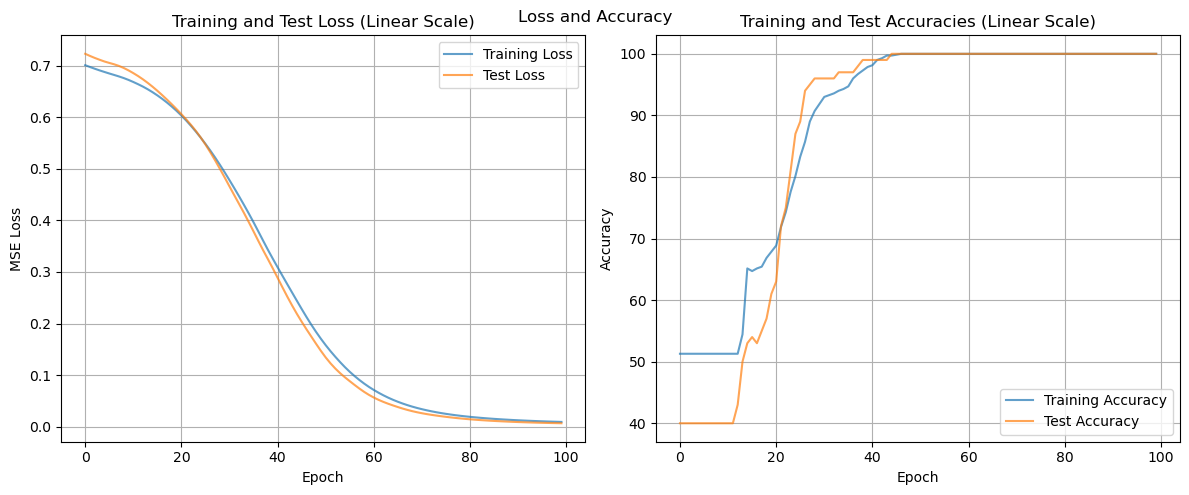

In [25]:
plot_loss_accuracy(train_losses_model_2, test_losses_model_2, train_accuracies_model_2, test_accuracies_model_2)

In [26]:
# Simple DataLoader Creation

def create_dataloaders_from_split(train_features, train_targets, test_features, test_targets, val_features, val_targets, batch_size=32):
    """
    Create DataLoaders from already split data
    """
    # Create TensorDatasets
    train_dataset = TensorDataset(train_features, train_targets)
    test_dataset = TensorDataset(test_features, test_targets)
    val_dataset = TensorDataset(val_features, val_targets)
    
    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,  # Shuffle training data
        drop_last=True  # Drop last incomplete batch
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False  # No shuffle for testing
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False  # No shuffle for validation
    )
    
    # Print dataset sizes
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Test batches: {len(test_loader)}")
    
    return train_loader, test_loader, val_loader

In [27]:
train_loader, test_loader, val_loader = create_dataloaders_from_split(X_train, y_train, X_test, y_test, X_val, y_val, batch_size=32)

Training samples: 700
Validation samples: 200
Test samples: 100
Training batches: 21
Validation batches: 7
Test batches: 4


In [28]:
class ThreeHiddenLayerBinaryClassifier(nn.Module):
    def __init__(self, input_size=2, hidden_size=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, hidden_size//4),
            nn.ReLU(),
            nn.Linear(hidden_size//4, 1),  # raw output (no sigmoid)
            nn.Sigmoid() # # Output probability between 0 and 1
        )

    def forward(self, x):
        return self.net(x)


In [29]:
learning_rate = 0.1
model_3 = ThreeHiddenLayerBinaryClassifier(input_size=2, hidden_size=16)

criterion = nn.BCELoss()  # ← Use BCELoss instead of BCEWithLogitsLoss since you have Sigmoid
optimizer = optim.Adam(model_3.parameters(), lr=learning_rate)

In [30]:
print(model_3)

ThreeHiddenLayerBinaryClassifier(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [31]:
print(X_train.shape)
summary(model_3, input_size=torch.Size([21,32, 2])) # [Num_batchs, batchs_size, input_features]

torch.Size([700, 2])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 21, 32, 16]              48
              ReLU-2           [-1, 21, 32, 16]               0
            Linear-3            [-1, 21, 32, 8]             136
              ReLU-4            [-1, 21, 32, 8]               0
            Linear-5            [-1, 21, 32, 4]              36
              ReLU-6            [-1, 21, 32, 4]               0
            Linear-7            [-1, 21, 32, 1]               5
           Sigmoid-8            [-1, 21, 32, 1]               0
Total params: 225
Trainable params: 225
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.30
Params size (MB): 0.00
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


In [32]:

def train_model_with_dataloaders(model, train_loader, test_loader, epochs=200):

    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss, epoch_train_acc = 0, 0

        # ---- TRAINING LOOP ----
        for batch_features, batch_targets in train_loader:
            batch_features, batch_targets = batch_features, batch_targets
            
            optimizer.zero_grad()
            batch_predictions = model(batch_features)
            batch_loss = criterion(batch_predictions, batch_targets)
            batch_acc = accuracy_fn(batch_targets, batch_predictions)

            batch_loss.backward()
            optimizer.step()

            epoch_train_loss += batch_loss.item()
            epoch_train_acc += batch_acc

        # Average over all batches
        epoch_train_loss /= len(train_loader)
        epoch_train_acc /= len(train_loader)

        # ---- EVALUATION LOOP ----
        model.eval()
        epoch_test_loss, epoch_test_acc = 0, 0
        with torch.no_grad():
            for batch_features, batch_targets in test_loader:
                batch_features, batch_targets = batch_features, batch_targets
                batch_predictions = model(batch_features)
                batch_loss = criterion(batch_predictions, batch_targets)
                batch_acc = accuracy_fn(batch_targets, batch_predictions)

                epoch_test_loss += batch_loss.item()
                epoch_test_acc += batch_acc

        epoch_test_loss /= len(test_loader)
        epoch_test_acc /= len(test_loader)

        # Store results
        train_losses.append(epoch_train_loss)
        test_losses.append(epoch_test_loss)
        train_accuracies.append(epoch_train_acc)
        test_accuracies.append(epoch_test_acc)

        # Print every 100 epochs
        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}] | "
                  f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}% | "
                  f"Test Loss: {epoch_test_loss:.4f} | Test Acc: {epoch_test_acc:.2f}%")


    return train_losses, test_losses, train_accuracies, test_accuracies


In [33]:
# Train the model_1
print("Model is going to training ...")
train_losses_model_3, test_losses_model_3, train_accuracies_model_3, test_accuracies_model_3 = train_model_with_dataloaders(
    model_3, train_loader, test_loader, epochs=100)

Model is going to training ...
Epoch [0/100] | Train Loss: 0.5647 | Train Acc: 69.79% | Test Loss: 0.5518 | Test Acc: 70.31%
Epoch [10/100] | Train Loss: 0.0028 | Train Acc: 100.00% | Test Loss: 0.0036 | Test Acc: 100.00%
Epoch [20/100] | Train Loss: 0.0011 | Train Acc: 100.00% | Test Loss: 0.0014 | Test Acc: 100.00%
Epoch [30/100] | Train Loss: 0.0006 | Train Acc: 100.00% | Test Loss: 0.0008 | Test Acc: 100.00%
Epoch [40/100] | Train Loss: 0.0004 | Train Acc: 100.00% | Test Loss: 0.0005 | Test Acc: 100.00%
Epoch [50/100] | Train Loss: 0.0003 | Train Acc: 100.00% | Test Loss: 0.0004 | Test Acc: 100.00%
Epoch [60/100] | Train Loss: 0.0002 | Train Acc: 100.00% | Test Loss: 0.0003 | Test Acc: 100.00%
Epoch [70/100] | Train Loss: 0.0001 | Train Acc: 100.00% | Test Loss: 0.0002 | Test Acc: 100.00%
Epoch [80/100] | Train Loss: 0.0001 | Train Acc: 100.00% | Test Loss: 0.0002 | Test Acc: 100.00%
Epoch [90/100] | Train Loss: 0.0001 | Train Acc: 100.00% | Test Loss: 0.0001 | Test Acc: 100.00%


In [34]:
# Evaluate the model
def evaluate_model_dataloader(model, val_loader):
    model.eval()
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            return loss.item(), predictions

val_loss, val_predictions = evaluate_model_dataloader(model_3, val_loader)
print(f"\nTest Loss: {val_loss:.4f}")


Test Loss: 0.0001


In [35]:
predicted_label = round(predict(model_3, 1, 1))
print("Predicted label is: ", predicted_label)

Predicted label is:  0


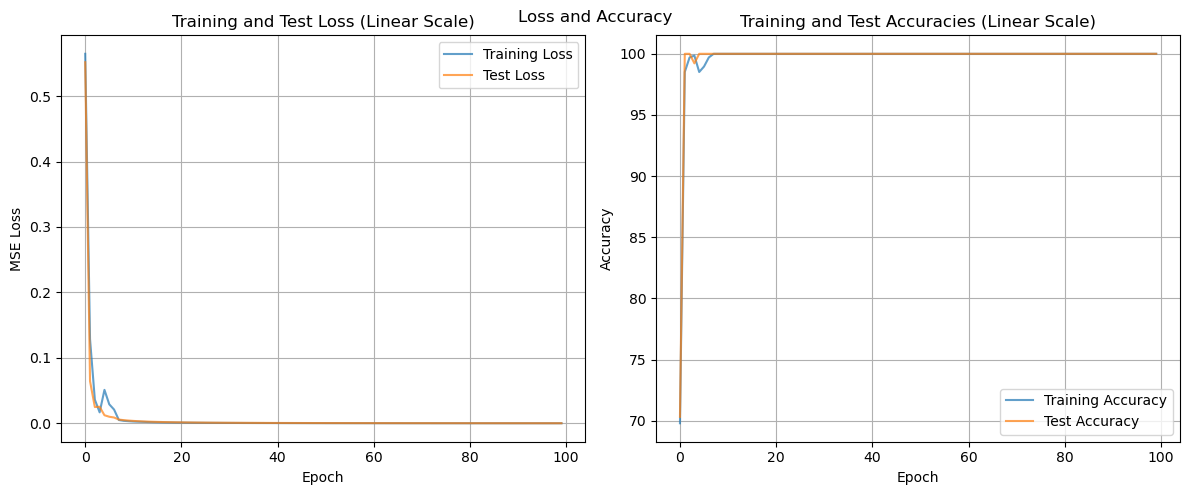

In [36]:
plot_loss_accuracy(train_losses_model_3, test_losses_model_3, train_accuracies_model_3, test_accuracies_model_3)

In [37]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def train_model_with_early_stopping_batch(model, train_loader, test_loader, epochs=50, patience=5):

    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
    best_loss, trigger_times = float('inf'), 0

    for epoch in range(epochs):
        model.train()
        epoch_train_loss, epoch_train_acc = 0, 0

        # ---- TRAINING LOOP ----
        for batch_features, batch_targets in train_loader:
            batch_features, batch_targets = batch_features, batch_targets

            optimizer.zero_grad()
            batch_predictions = model(batch_features)
            batch_loss = criterion(batch_predictions, batch_targets)
            batch_acc = accuracy_fn(batch_targets, batch_predictions)

            batch_loss.backward()
            optimizer.step()

            epoch_train_loss += batch_loss.item()
            epoch_train_acc += batch_acc

        # Average over all batches
        epoch_train_loss /= len(train_loader)
        epoch_train_acc /= len(train_loader)

        # ---- EVALUATION LOOP ----
        model.eval()
        epoch_test_loss, epoch_test_acc = 0, 0
        with torch.no_grad():
            for batch_features, batch_targets in test_loader:
                batch_features, batch_targets = batch_features, batch_targets
                batch_predictions = model(batch_features)
                batch_loss = criterion(batch_predictions, batch_targets)
                batch_acc = accuracy_fn(batch_targets, batch_predictions)

                epoch_test_loss += batch_loss.item()
                epoch_test_acc += batch_acc

        epoch_test_loss /= len(test_loader)
        epoch_test_acc /= len(test_loader)

        # Store results
        train_losses.append(epoch_train_loss)
        test_losses.append(epoch_test_loss)
        train_accuracies.append(epoch_train_acc)
        test_accuracies.append(epoch_test_acc)

        # Print every 100 epochs
        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}] | "
                  f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}% | "
                  f"Test Loss: {epoch_test_loss:.4f} | Test Acc: {epoch_test_acc:.2f}%")

        # Early stopping
        if epoch_test_loss < best_loss:
            best_loss, trigger_times = epoch_test_loss, 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping triggered!")
                break

    return train_losses, test_losses, train_accuracies, test_accuracies


In [38]:
learning_rate = 0.1
model_4 = ThreeHiddenLayerBinaryClassifier(input_size=2, hidden_size=16)

criterion = nn.BCELoss()  # ← Use BCELoss instead of BCEWithLogitsLoss since you have Sigmoid
optimizer = optim.Adam(model_4.parameters(), lr=learning_rate)

In [39]:
print(X_train.shape)
summary(model_4, input_size=torch.Size([21,32, 2])) # [Num_batchs, batchs_size, input_features]

torch.Size([700, 2])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 21, 32, 16]              48
              ReLU-2           [-1, 21, 32, 16]               0
            Linear-3            [-1, 21, 32, 8]             136
              ReLU-4            [-1, 21, 32, 8]               0
            Linear-5            [-1, 21, 32, 4]              36
              ReLU-6            [-1, 21, 32, 4]               0
            Linear-7            [-1, 21, 32, 1]               5
           Sigmoid-8            [-1, 21, 32, 1]               0
Total params: 225
Trainable params: 225
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.30
Params size (MB): 0.00
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


In [40]:
# Train the model_1
print("Model is going to training ...")
train_losses_model_4, test_losses_model_4, train_accuracies_model_4, test_accuracies_model_4 = train_model_with_early_stopping_batch(
    model_4, train_loader, test_loader, epochs=100, patience=3)

Model is going to training ...
Epoch [0/100] | Train Loss: 0.3995 | Train Acc: 82.89% | Test Loss: 0.0035 | Test Acc: 100.00%
Epoch [10/100] | Train Loss: 0.0001 | Train Acc: 100.00% | Test Loss: 0.0001 | Test Acc: 100.00%
Epoch [20/100] | Train Loss: 0.0000 | Train Acc: 100.00% | Test Loss: 0.0000 | Test Acc: 100.00%
Epoch [30/100] | Train Loss: 0.0000 | Train Acc: 100.00% | Test Loss: 0.0000 | Test Acc: 100.00%
Epoch [40/100] | Train Loss: 0.0000 | Train Acc: 100.00% | Test Loss: 0.0000 | Test Acc: 100.00%
Epoch [50/100] | Train Loss: 0.0000 | Train Acc: 100.00% | Test Loss: 0.0000 | Test Acc: 100.00%
Epoch [60/100] | Train Loss: 0.0000 | Train Acc: 100.00% | Test Loss: 0.0000 | Test Acc: 100.00%
Epoch [70/100] | Train Loss: 0.0000 | Train Acc: 100.00% | Test Loss: 0.0000 | Test Acc: 100.00%
Epoch [80/100] | Train Loss: 0.0000 | Train Acc: 100.00% | Test Loss: 0.0000 | Test Acc: 100.00%
Epoch [90/100] | Train Loss: 0.0000 | Train Acc: 100.00% | Test Loss: 0.0000 | Test Acc: 100.00%


In [41]:
# Evaluate the model
val_loss, val_predictions = evaluate_model_dataloader(model_4, val_loader)
print(f"\nTest Loss: {val_loss:.4f}")


Test Loss: 0.0000


In [42]:
predicted_label = round(predict(model_4, 1, 1))
print("Predicted label is: ", predicted_label)

Predicted label is:  0


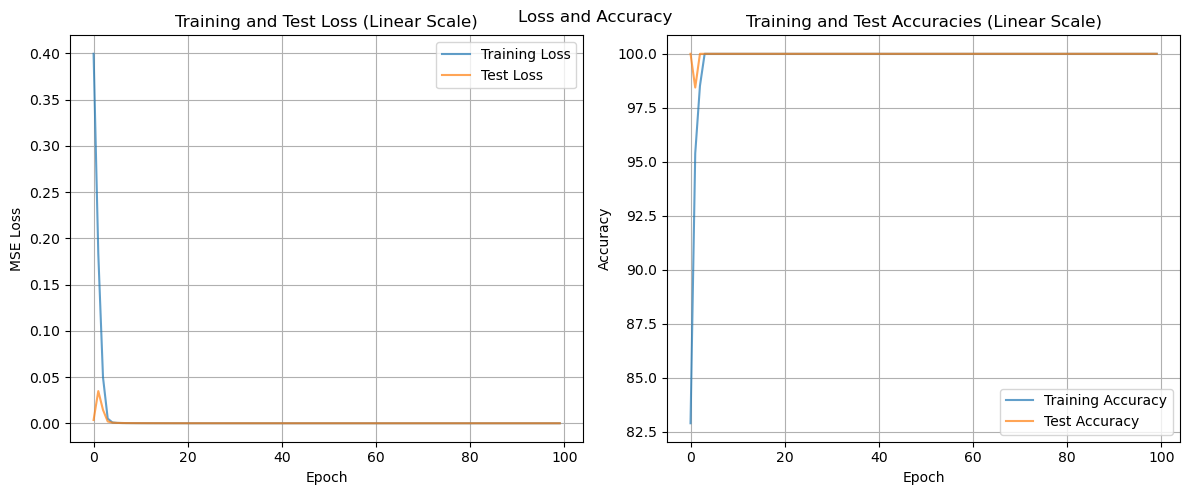

In [43]:
plot_loss_accuracy(train_losses_model_4, test_losses_model_4, train_accuracies_model_4, test_accuracies_model_4)

In [44]:
# Evaluation metrics:

def evaluation_metrics(model, validation_features, validation_labels):
    y_true = validation_labels
    y_pred = (model(X_val)>0.5).float()
    correct = (y_true == y_pred).sum().item()
    accuracy = correct / len(y_true)
    accuracy * 100

    TP = ((y_true == 1) & (y_pred == 1)).sum().item()
    FP = ((y_true == 0) & (y_pred == 1)).sum().item()
    FN = ((y_true == 1) & (y_pred == 0)).sum().item()
    
    precision = TP / (TP + FP + 1e-8)  # avoid division by zero
    recall = TP / (TP + FN + 1e-8)
    f1_Score = 2 * (precision * recall) / (precision + recall + 1e-8)

    return accuracy, precision, recall, f1_Score 

models = [model_1, model_2, model_3, model_4]  # Your actual model objects
for i, model in enumerate(models):
    accuracy, precision, recall, f1_score = evaluation_metrics(model, X_val, y_val)
    print(f"Model {i}: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1-Score={f1_score:.4f}")


Model 0: Accuracy=0.5900, Precision=0.5739, Recall=0.6667, F1-Score=0.6168
Model 1: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1-Score=1.0000
Model 2: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1-Score=1.0000
Model 3: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1-Score=1.0000


In [45]:
def confusion_matrix_fn(model, validation_features, validation_labels):
    y_true = validation_labels
    y_pred = (model(X_val)>0.5).float()
    cm = confusion_matrix(y_true.cpu().numpy(), y_pred.cpu().numpy())
    return cm

print(confusion_matrix_fn(model_4, X_val, y_val))

[[101   0]
 [  0  99]]


In [46]:
def classification_report_fn(model, validation_features, validation_labels):
    y_true = validation_labels
    y_pred = (model(X_val)>0.5).float()
    report = classification_report(y_true.cpu().numpy(), y_pred.cpu().numpy())
    return report

print(classification_report_fn(model_4, X_val, y_val))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       101
         1.0       1.00      1.00      1.00        99

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

